# Example (4) 家賃の回帰問題 (regression)

- 基本的に，["Deep Learning with Python"](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/)のSection 3.6(85-91ページ)を元にしている．  
- [原本のコード](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.7-predicting-house-prices.ipynb)も入手可能であるが，それを解説を兼ねて多少改編している．  

## (1) Prepare dataset: Boston housing price dataset

- Data format: [N,13]  
- Training set: 404  
- Test set: 102  
- 家賃に影響を及ぼす13個の数値要素  

In [1]:
## boston housing price dataset is embedded in Keras framework
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
## objective: housing price (USD 5K~50K)
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

## (2) Data conversion for training

- training データを正規分布に落とす  
  + まず，数値を平均値で引くことで**平均=0.0**にする  
  + その後，標準偏差で割ることで**分散=1.0**にする  
- test データにも同様な変換を施す  

In [4]:
## normalize training data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

## normalize test data by using the mean/std of training data
test_data -= mean
test_data /= std

In [5]:
print(train_data)
print(test_data)

[[-0.27224633 -0.48361547 -0.43576161 ...  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 ... -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  ...  0.78447637  0.22061726
  -1.30850006]
 ...
 [-0.40202987  0.99079651 -0.7415148  ... -0.71712291  0.07943894
  -0.67776904]
 [-0.17292018 -0.48361547  1.24588095 ... -1.71818909 -0.98764362
   0.42083466]
 [-0.40422614  2.04394792 -1.20161456 ... -1.30866202  0.23317118
  -1.15392266]]
[[ 1.55369355 -0.48361547  1.0283258  ...  0.78447637 -3.48459553
   2.25092074]
 [-0.39242675 -0.48361547 -0.16087773 ... -0.30759583  0.42733126
   0.47880119]
 [-0.39982927 -0.48361547 -0.86940196 ...  0.78447637  0.44807713
  -0.41415936]
 ...
 [-0.20709507 -0.48361547  1.24588095 ... -1.71818909  0.37051949
  -1.49344089]
 [-0.36698601 -0.48361547 -0.72093526 ... -0.48960787  0.39275481
  -0.41829982]
 [-0.0889679  -0.48361547  1.24588095 ... -1.71818909 -1.21946544
  -0.40449827]]


## (3) Prepare model

- Fully connectedで(隠し2層)単純なネットワークを構成する  
- 回帰問題(regression)なので，訓練のloss関数としてMSE(Mean Squared Error)を用いる  
- 尺度はMAE(Mean Absolute Error)  

In [6]:
from keras import models
from keras import layers

# we need to instantiate the same model multiple times
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## (4) Training & testing neural network

### (4-i) Training model - K-fold validation

- 部分データを検証(validation，ここでは1/4)データとして除外し，  
  残りデータを学習させて学習結果を検証データに適用することで得られる誤差の平均値から  
  (全データを用いた)最終的な学習で得られる誤差を事前に見積もることが出来る (?)  
- 本学習の前に，現在のモデルで最終的に期待される誤差を事前に見積もりたい (?)  

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    
    # prepare the validation data: data from partition # k
    val_data    = train_data   [i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # train the model
    model = build_model() ## untrained model for validation
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    # evaluate the model after the training
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
## validation scores valied
print(all_scores)
print(np.mean(all_scores))

[2.132859706878662, 2.5821452140808105, 2.3736162185668945, 2.2671024799346924]
2.338930904865265


### (4-ii) Training model - with many epochs (overfitting)

- 先ほど用いたepochs数は学習に十分なものだったのか，まだ十分でなかったのかは判断できない  
- そこで，epochs数を増やせ，推移を観察することで過学習が起きているかどうかが見積もれる  

In [9]:
from keras import backend as K

# clean-up memory
K.clear_session()

In [10]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    
    # prepare the validation data: data from partition # k
    val_data    = train_data   [i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # train the model
    model = build_model() ## untrained model for validation
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets), ## validation is included here
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    # pick-up the validation loss
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


### (4-iii) Visualization

Validation MAEの推移がよく見れるように，プロットの方法を少し改善させる  
- 最初の10 epochs程度は推移に重要でない上，有効な情報を持っていないので省略させる  
- プロットの細かい上下はあまり重要でなく，データ推移観測の邪魔になるので補完を行う  

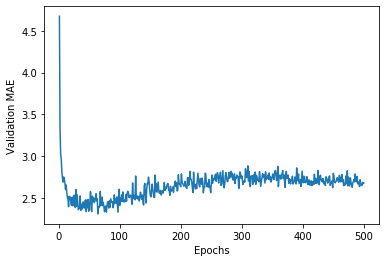

In [11]:
import matplotlib.pyplot as plt

## get the average of mean absolute error
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## plot raw-data (not so good to observe the progress)
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

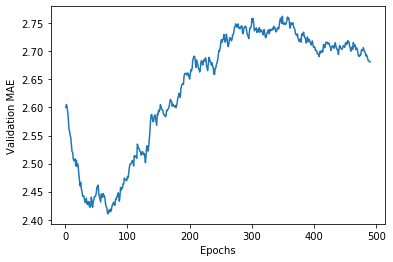

In [12]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

## skipping the first 10 & smoothing plot
smooth_mae_history = smooth_curve(average_mae_history[10:])

## plot (better to observe the progress)
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### (4-iv) Final production model for the regression

- 前のテストで明示的な改善の見られないepochs数(~=80)を用いて本学習を行う  
- 少ないepochs数でも十分な精度が得られていることが確認できる  

In [13]:
## get a fresh model
model = build_model()

## train with entire data
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 166us/step


In [14]:
## we can still get the good result with small #epochs
print(test_mae_score)

2.795032024383545


(end)